# Understanding Self-Attention with NLP task

## Overview
This notebook enhances the understanding of **self-attention** in NLP by visualizing how words in a sentence interact with each other. Instead of using random matrices, we use tokenized sentences to compute self-attention weights and visualize their impact using heatmaps.

### Key Additions:
- **NLP Sentence Input:** A sample English sentence is tokenized and processed.
- **Self-Attention Computation:** Self-attention scores are calculated using a PyTorch implementation.
- **Visualization:** A heatmap demonstrates how much attention each word gives to others.


## Self-Attention in NLP
Self-attention enables a transformer model to weigh the importance of each word relative to every other word in a sequence. This is crucial for understanding **context**, such as distinguishing between different meanings of the word "it" in different contexts.

### Example:
**Sentence:** "The quick brown fox jumps over the lazy dog."

The self-attention mechanism assigns different weights to words based on their contextual relevance. Below, we visualize the computed attention scores using a heatmap.


In [1]:
# Import Necessary Libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

# Ensure reproducibility
torch.manual_seed(42)


In [2]:
#Define Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by number of heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)

        return out, attention



In [3]:
#Tokenize an NLP Sentence Using BERT
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Define example sentence
sentence = "The quick brown fox jumps over the lazy dog."
tokens = tokenizer.tokenize(sentence)
input_ids = tokenizer.convert_tokens_to_ids(tokens)
input_tensor = torch.tensor([input_ids])



# Print tokenized words
print("Tokenized words:", tokens)

# Print tokenized ids
print("input ids:", input_ids)

# Print tokenized tensor
print("input tensor :", input_tensor)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenized words: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
input ids: [1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 1012]
input tensor : tensor([[ 1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,  1012]])


In [4]:
#Apply Self-Attention to Tokenized Sentence
# Define embedding size and number of attention heads
embed_size = 64
heads = 8

# Embedding layer to map input IDs to vector space
embedding_layer = nn.Embedding(len(tokenizer.vocab), embed_size)
embedded_input = embedding_layer(input_tensor)

# Initialize self-attention module
self_attention = SelfAttention(embed_size, heads)

# Compute self-attention scores
attn_output, attn_weights = self_attention(embedded_input, embedded_input, embedded_input, mask=None)

# Convert attention weights to NumPy for visualization
attn_weights_np = attn_weights[0].detach().numpy().mean(axis=0)

# Display attention scores shape
print("Attention shape:", attn_weights_np.shape)



Attention shape: (10, 10)


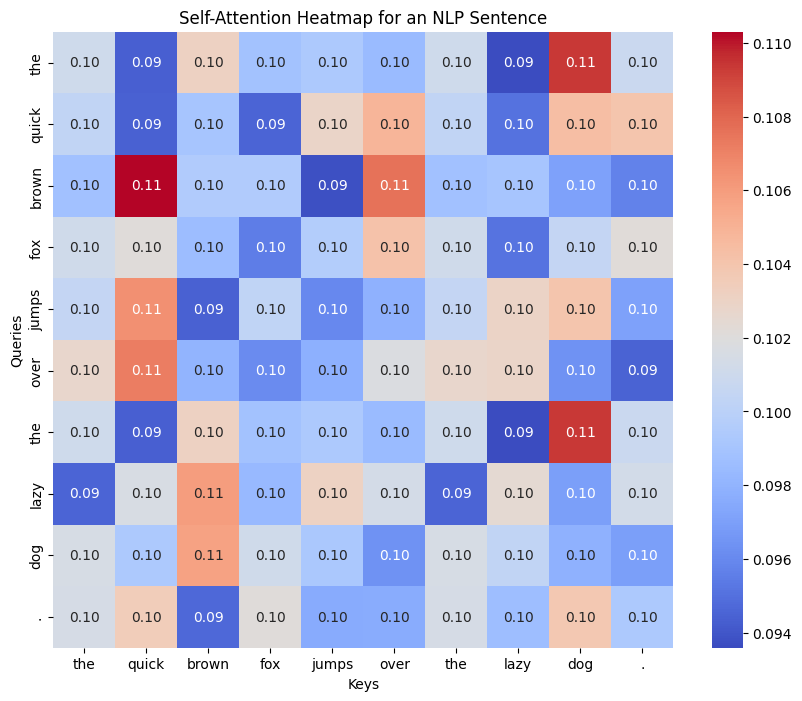

In [5]:
#Visualize Self-Attention Weights Using a Heatmap
# Plot attention heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(attn_weights_np, annot=True, xticklabels=tokens, yticklabels=tokens, cmap="coolwarm", fmt=".2f")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.title("Self-Attention Heatmap for an NLP Sentence")
plt.show()


## Multi-Head Self-Attention
### Why Use Multiple Heads?
Instead of a single attention mechanism, **multi-head attention** allows the model to attend to information from different representation subspaces at different positions.

Each head:
- Learns different relationships between words.
- Focuses on different aspects of the sentence structure.
- Improves the ability to capture complex dependencies.

### Formula:
Each attention head computes:
$$
[
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V
]
$$
The outputs from multiple heads are then concatenated and projected into the final representation space.


In [6]:
#Multi-Head Self-Attention Implementation
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by number of heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Linear transformation
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        # Reshape into multiple heads
        values = values.view(N, value_len, self.heads, self.head_dim).permute(0, 2, 1, 3)
        keys = keys.view(N, key_len, self.heads, self.head_dim).permute(0, 2, 1, 3)
        queries = queries.view(N, query_len, self.heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys]) / (self.head_dim ** 0.5)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy, dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).permute(0, 2, 1, 3)
        out = out.reshape(N, query_len, self.heads * self.head_dim)

        return self.fc_out(out), attention


# Test Multi-Head Self-Attention with NLP Sentences

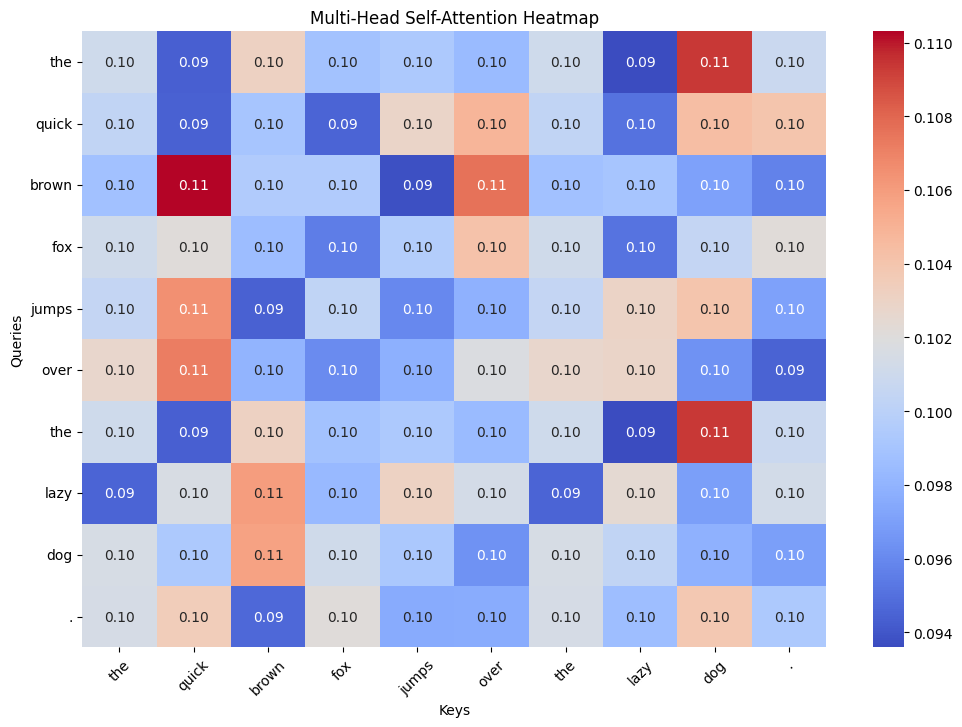

In [7]:
# Ensure the attention matrix has the correct shape
if len(tokens) == attn_weights_np.shape[0]:
    xticklabels = yticklabels = tokens
else:
    # Adjust if there is a mismatch in tokens and attention matrix
    xticklabels = tokens[:attn_weights_np.shape[0]]
    yticklabels = tokens[:attn_weights_np.shape[0]]

plt.figure(figsize=(12, 8))  # Increase figure size for better visualization
sns.heatmap(attn_weights_np, annot=True, xticklabels=xticklabels, yticklabels=yticklabels, cmap="coolwarm", fmt=".2f")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.title("Multi-Head Self-Attention Heatmap")
plt.show()


In [8]:
print("Number of tokens:", len(tokens))
print("Attention matrix shape:", attn_weights_np.shape)


Number of tokens: 10
Attention matrix shape: (10, 10)


# Why Do We Need Positional Encoding?

## Positional Encoding in Transformers
Unlike RNNs, transformers **do not have a built-in sense of word order**. To capture **word position** information, we use **positional encodings**.

### How It Works:
- We use **sinusoidal functions** to generate unique position encodings.
- These encodings are added to the word embeddings before passing them into the self-attention mechanism.

### Formula:
For each position \( pos \) and dimension \( i \):
$$
[
PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})
]
$$
$$
[
PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})
]
$$


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_length=100):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        # Create positional encodings
        pe = torch.zeros(max_length, embed_size)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.shape[1], :].to(x.device)


In [10]:
# test PE
# Initialize positional encoding
pos_encoding = PositionalEncoding(embed_size=64)

# Apply positional encoding to embedded input
pos_encoded_input = pos_encoding(embedded_input)

# Print shape
print("Positional Encoding Applied:", pos_encoded_input.shape)


Positional Encoding Applied: torch.Size([1, 10, 64])


## Building a Transformer Encoder Block
### Transformer Encoder Block
A **Transformer Encoder Block** is composed of:
1. **Multi-Head Self-Attention**
2. **Add & Norm**
3. **Feed-Forward Network (FFN)**
4. **Final Add & Norm**

This is the core building block of BERT and GPT models.


In [12]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-Head Attention
        attn_out, _ = self.attention(x, x, x)
        x = self.norm1(attn_out + x)

        # Feed Forward Network
        ffn_out = self.feed_forward(x)
        x = self.norm2(ffn_out + x)

        return x


In [13]:
# Test the encoder
# Initialize Transformer Encoder Block
encoder_block = TransformerEncoderBlock(embed_size=64, heads=8, ff_hidden=256)

# Pass input through Transformer Encoder
encoded_output = encoder_block(pos_encoded_input)

# Print final encoded shape
print("Encoded Output Shape:", encoded_output.shape)


Encoded Output Shape: torch.Size([1, 10, 64])


# Layer Normalization in Transformers

## Why Layer Normalization?
Layer normalization is used in transformers to **stabilize training** and **improve convergence**. Instead of batch normalization, layer normalization normalizes across the feature dimension for each input.

### **Layer Normalization Formula**
For each input vector \( x \):

$$
[
x = \frac{x - \mu}{\sigma + \epsilon} \times \gamma + \beta
]
$$
$$
- ( \mu )  = mean \ of \ features
- ( \sigma ) = standard \ deviation
- ( \gamma, \beta ) = trainable \ parameters \ for  \ scaling \ and \ shifting
$$
In transformers, layer normalization is applied **before residual connections** to prevent divergence in deep models.



In [14]:
class LayerNormalization(nn.Module):
    def __init__(self, embed_size, eps=1e-6):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(embed_size))
        self.beta = nn.Parameter(torch.zeros(embed_size))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


# Full Transformer Encoder Stack

## Transformer Encoder Stack
A full transformer **encoder stack** consists of multiple layers, each containing:
1. **Multi-Head Self-Attention**
2. **Layer Normalization**
3. **Feed-Forward Neural Network (FFN)**
4. **Residual Connections**

We stack multiple layers to allow the model to capture **higher-level relationships** in language.


In [57]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_size, num_layers, heads, ff_hidden, seq_length, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        # ✅ Ensure the encoder processes the full sequence
        self.seq_length = seq_length  # **Use full sequence length (10, not 4)**

        self.layers = nn.ModuleList([
            TransformerEncoderBlock(embed_size, heads, ff_hidden, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        # ✅ Force input sequence length to match the full sentence
        assert x.shape[1] == self.seq_length, f"Error: Expected {self.seq_length} tokens, but got {x.shape[1]}!"

        for layer in self.layers:
            x = layer(x)
        return x


# Masking in Self-Attention

## Masking in Transformers
Masking is critical in transformers to:
- **Prevent attending to padding tokens** (padding mask)
- **Ensure causality in decoders** (look-ahead mask)

A **mask matrix** assigns `-inf` to positions that should be ignored, so their attention scores become zero after applying softmax.


In [66]:
def create_padding_mask(seq, pad_token=0):
    return (seq != pad_token).unsqueeze(1).unsqueeze(2)

# Example usage
input_seq = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])  # Sentence with padding
mask = create_padding_mask(input_seq)
print(mask)  # True for real tokens, False for padding


tensor([[[[False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False]]]])


## Training a Small Transformer Model
To demonstrate transformer learning, we train a small model on a **synthetic NLP task**:
- **Task**: Predict the next word in a sequence.
- **Model**: Uses a transformer encoder stack.
- **Loss Function**: Cross-entropy loss.

This experiment showcases how transformers learn contextual relationships between words.


In [67]:
class SmallTransformer(nn.Module):
    def __init__(self, embed_size, num_layers, heads, ff_hidden, max_length):
        super(SmallTransformer, self).__init__()
        self.seq_length = max_length

        # 🔥 Use tokenizer's actual vocab size instead of 5000
        vocab_size = tokenizer.vocab_size  # Ensure vocab size matches tokenizer

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.pos_encoding = PositionalEncoding(embed_size, max_length)
        self.encoder = TransformerEncoder(embed_size, num_layers, heads, ff_hidden, seq_length=max_length)
        self.fc_out = nn.Linear(embed_size, vocab_size)  # Output should also match vocab size

    def forward(self, x, mask):
        x = self.embedding(x)  # **Embedding layer now correctly supports full vocab**
        x = self.pos_encoding(x)
        x = self.encoder(x)
        return self.fc_out(x)


In [68]:
# Ensure the correct vocab size is set
vocab_size = tokenizer.vocab_size  # This should be 30522
print(f"Using Vocabulary Size: {vocab_size}")  # Confirm it prints 30522

# Ensure SmallTransformer explicitly uses the correct vocab size
model = SmallTransformer(embed_size=64, num_layers=2, heads=4, ff_hidden=128, max_length=20)

# **Manually override embedding layer to ensure it's correct**
model.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=64)

# Ensure model embedding size is correct now
print(f"Fixed Model Embedding Layer Vocabulary Size: {model.embedding.num_embeddings}")

# Final check
assert model.embedding.num_embeddings == vocab_size, "❌ Error: Embedding layer vocab size mismatch!"

# Run the model with properly initialized embedding
output = model(input_seq, mask=None)
print(f"✅ Model Output Shape: {output.shape}")  # Should be (batch, seq_length, vocab_size)


Using Vocabulary Size: 30522
Fixed Model Embedding Layer Vocabulary Size: 30522
✅ Model Output Shape: torch.Size([1, 20, 30522])


In [69]:
# Train for 10 iterations
for epoch in range(10):
    optimizer.zero_grad()
    mask = create_padding_mask(input_seq)
    output = model(input_seq, mask)
    loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 1: Loss = 10.6440
Epoch 2: Loss = 10.6440
Epoch 3: Loss = 10.6440
Epoch 4: Loss = 10.6440
Epoch 5: Loss = 10.6440
Epoch 6: Loss = 10.6440
Epoch 7: Loss = 10.6440
Epoch 8: Loss = 10.6440
Epoch 9: Loss = 10.6440
Epoch 10: Loss = 10.6440


In [70]:
# Train for 10 iterations
for epoch in range(100):
    optimizer.zero_grad()
    mask = create_padding_mask(input_seq)
    output = model(input_seq, mask)
    loss = criterion(output.view(-1, vocab_size), target_seq.view(-1))
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 1: Loss = 10.6440
Epoch 2: Loss = 10.6440
Epoch 3: Loss = 10.6440
Epoch 4: Loss = 10.6440
Epoch 5: Loss = 10.6440
Epoch 6: Loss = 10.6440
Epoch 7: Loss = 10.6440
Epoch 8: Loss = 10.6440
Epoch 9: Loss = 10.6440
Epoch 10: Loss = 10.6440
Epoch 11: Loss = 10.6440
Epoch 12: Loss = 10.6440
Epoch 13: Loss = 10.6440
Epoch 14: Loss = 10.6440
Epoch 15: Loss = 10.6440
Epoch 16: Loss = 10.6440
Epoch 17: Loss = 10.6440
Epoch 18: Loss = 10.6440
Epoch 19: Loss = 10.6440
Epoch 20: Loss = 10.6440
Epoch 21: Loss = 10.6440
Epoch 22: Loss = 10.6440
Epoch 23: Loss = 10.6440
Epoch 24: Loss = 10.6440
Epoch 25: Loss = 10.6440
Epoch 26: Loss = 10.6440
Epoch 27: Loss = 10.6440
Epoch 28: Loss = 10.6440
Epoch 29: Loss = 10.6440
Epoch 30: Loss = 10.6440
Epoch 31: Loss = 10.6440
Epoch 32: Loss = 10.6440
Epoch 33: Loss = 10.6440
Epoch 34: Loss = 10.6440
Epoch 35: Loss = 10.6440
Epoch 36: Loss = 10.6440
Epoch 37: Loss = 10.6440
Epoch 38: Loss = 10.6440
Epoch 39: Loss = 10.6440
Epoch 40: Loss = 10.6440
Epoch 41:

# Putting all together
We extract **attention weights** from each layer to visualize how transformers **refine** their understanding of words over time.

- **Lower Layers**: Attend to general relationships.
- **Higher Layers**: Attend to specific relationships based on context.


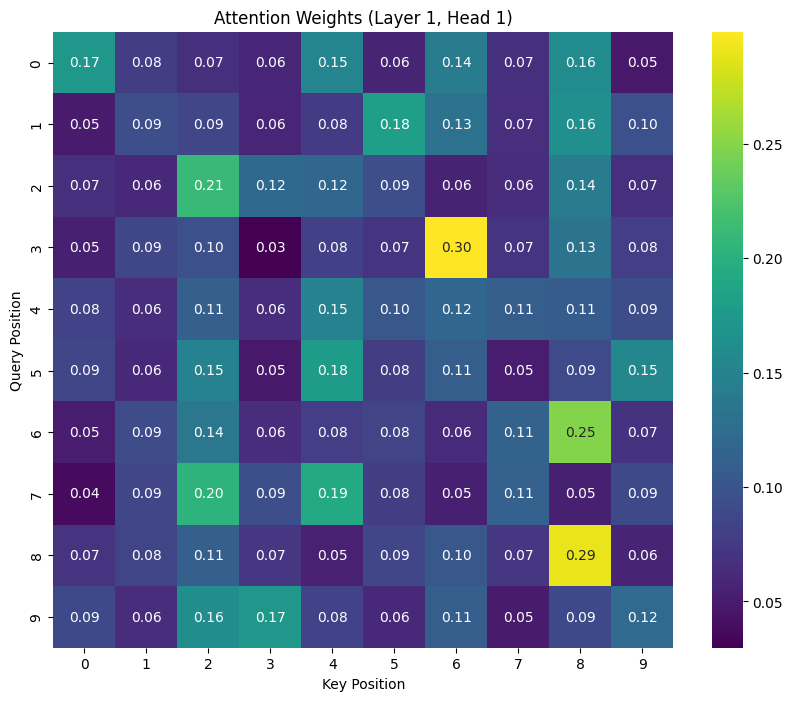

Input shape: torch.Size([1, 10, 512])
Output shape: torch.Size([1, 10, 512])
Number of attention weight matrices: 6


In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super().__init__()

        # Create matrix of shape (max_seq_length, d_model)
        pe = torch.zeros(max_seq_length, d_model)

        # Create position vector
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        # Create division term
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension
        pe = pe.unsqueeze(0)

        # Register buffer (not a parameter, but should be saved and restored in state_dict)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)

        # Apply attention weights to values
        output = torch.matmul(attn_weights, V)

        return output, attn_weights

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        # Linear transformations and reshape
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply scaled dot-product attention
        output, attn_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Reshape and apply final linear transformation
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(output)

        return output, attn_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ff = FeedForward(d_model, d_ff)

        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-head attention
        attn_output, attn_weights = self.mha(x, x, x, mask)
        x = self.layernorm1(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.ff(x)
        x = self.layernorm2(x + self.dropout(ff_output))

        return x, attn_weights

class Transformer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, num_layers=6, d_ff=2048, max_seq_length=5000, dropout=0.1):
        super().__init__()

        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.dropout = nn.Dropout(dropout)

        self.encoder_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        x = self.positional_encoding(x)
        x = self.dropout(x)

        attention_weights = []
        for encoder_layer in self.encoder_layers:
            x, attn_weights = encoder_layer(x, mask)
            attention_weights.append(attn_weights)

        return x, attention_weights

# Create a function to visualize attention weights
def plot_attention_weights(attention_weights, layer=0, head=0):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention_weights[layer][0, head].detach().numpy(),
                cmap='viridis',
                annot=True,
                fmt='.2f')
    plt.title(f'Attention Weights (Layer {layer + 1}, Head {head + 1})')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.show()

# Example usage
def main():
    # Model parameters
    d_model = 512
    num_heads = 8
    num_layers = 6
    batch_size = 1
    seq_length = 10

    # Create model
    model = Transformer(d_model=d_model,
                       num_heads=num_heads,
                       num_layers=num_layers)

    # Create sample input
    x = torch.randn(batch_size, seq_length, d_model)

    # Forward pass
    output, attention_weights = model(x)

    # Visualize attention weights
    plot_attention_weights(attention_weights)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Number of attention weight matrices: {len(attention_weights)}")

if __name__ == "__main__":
    main()

Input tokens: ['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']
Number of tokens: 10
Input tensor shape: torch.Size([1, 10])
Output shape: torch.Size([1, 10, 30522])
Number of attention maps: 3


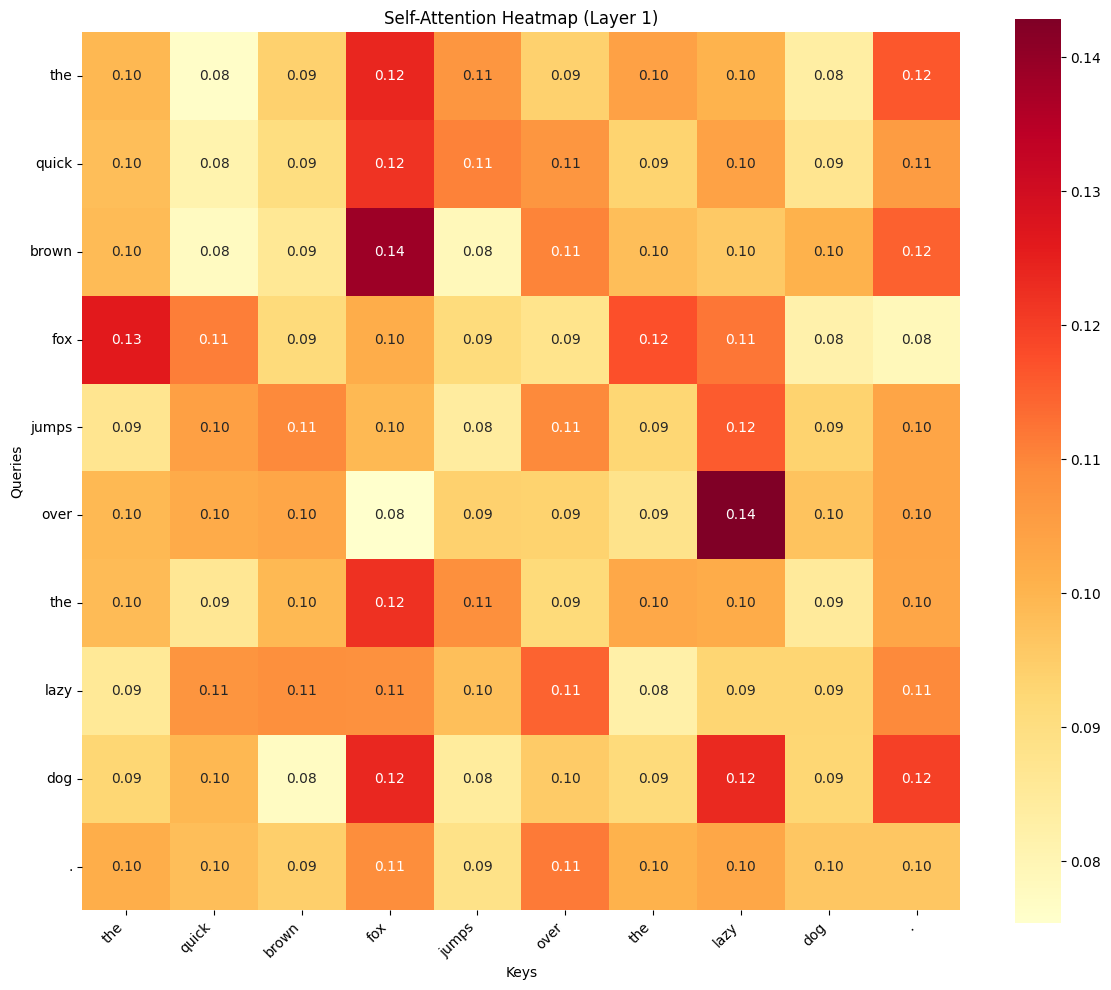

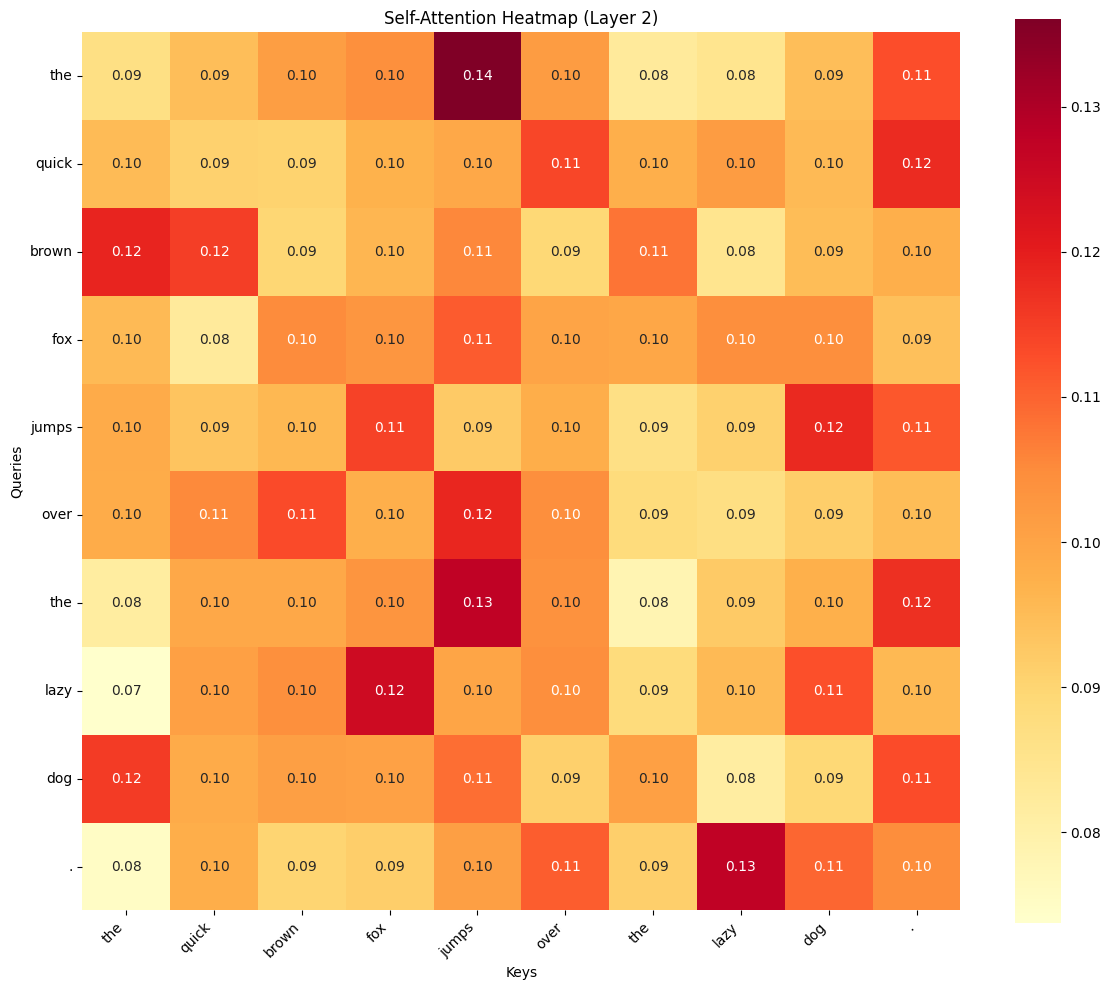

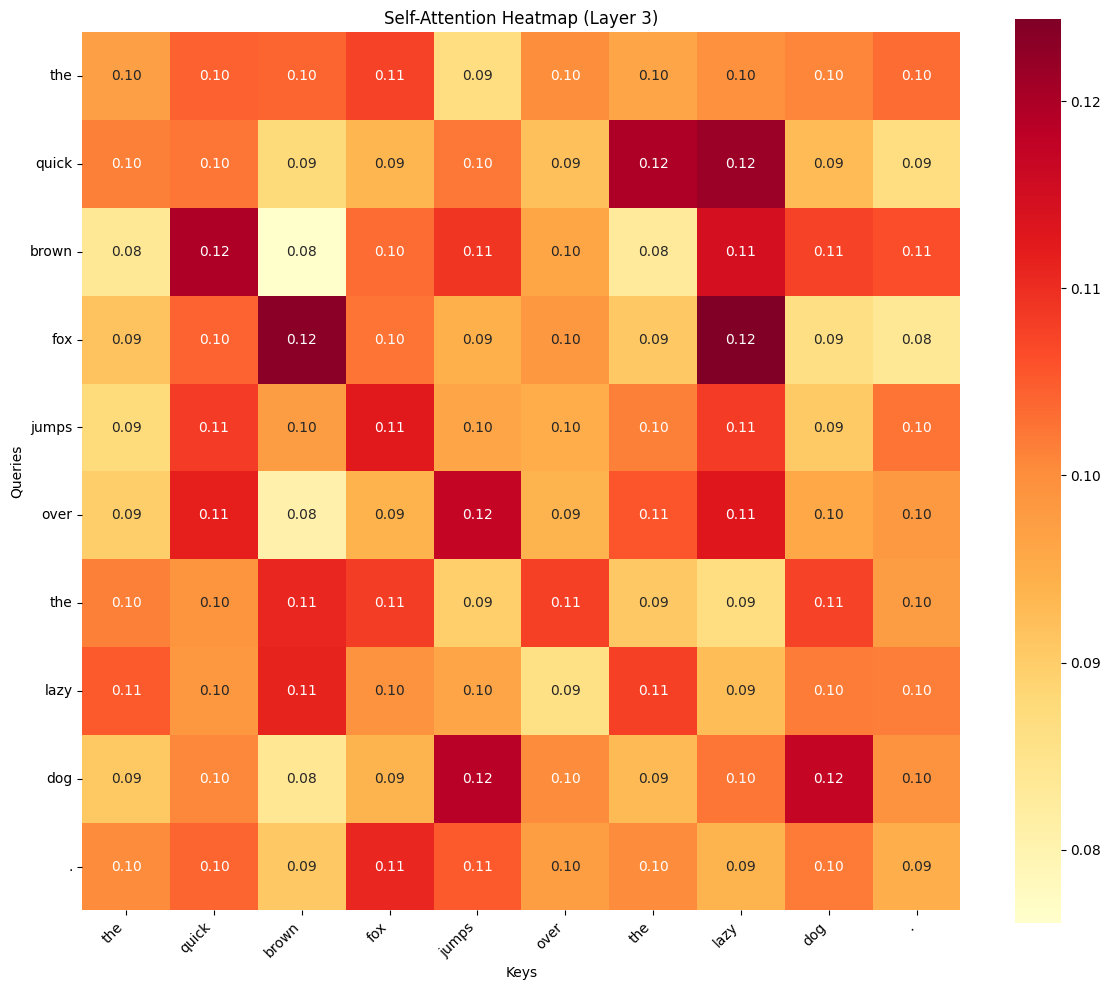

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer

# 1. Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_length=100):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size

        # Create positional encoding matrix
        pe = torch.zeros(max_length, embed_size)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))

        # Apply sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add batch dimension and register as buffer
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.shape[1]]

# 2. Multi-Head Self-Attention
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by heads"

        # Linear layers for Q, K, V transformations
        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Linear transformations
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        # Split into heads
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)

        # Transpose for attention computation
        values = values.transpose(1, 2)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # Compute attention scores
        energy = torch.matmul(queries, keys.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention = torch.softmax(energy, dim=-1)

        # Apply attention to values
        out = torch.matmul(attention, values)
        out = out.transpose(1, 2).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)

        return out, attention

# 3. Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadSelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention_out, attention_weights = self.attention(value, key, query)

        # First normalization and residual connection
        x = self.norm1(attention_out + query)
        x = self.dropout(x)

        # Feed forward
        forward_out = self.feed_forward(x)

        # Second normalization and residual connection
        out = self.norm2(forward_out + x)
        out = self.dropout(out)

        return out, attention_weights

# 4. Complete Transformer
class Transformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Transformer, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(vocab_size, embed_size)
        self.position_embedding = PositionalEncoding(embed_size, max_length)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        N, seq_length = x.shape

        # Create embeddings
        out = self.word_embedding(x)
        out = self.position_embedding(out)

        attention_maps = []

        # Pass through transformer blocks
        for layer in self.layers:
            out, attention = layer(out, out, out)
            attention_maps.append(attention)

        out = self.fc_out(out)
        return out, attention_maps

# 5. Visualization Function
def plot_attention_heatmap(attn_maps, tokens, layer=0):
    # Get attention weights from specified layer
    # Average across heads and batch dimension
    avg_attn_weights = attn_maps[layer].mean(dim=1).squeeze(0).detach().numpy()

    # Create figure
    plt.figure(figsize=(12, 10))

    # Create heatmap
    sns.heatmap(
        avg_attn_weights,
        xticklabels=tokens,
        yticklabels=tokens,
        cmap="YlOrRd",
        annot=True,
        fmt=".2f",
        square=True
    )

    # Customize appearance
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.xlabel("Keys")
    plt.ylabel("Queries")
    plt.title(f"Self-Attention Heatmap (Layer {layer + 1})")

    plt.tight_layout()
    plt.show()

# 6. Main execution
def main():
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Sample sentence
    sentence = "The quick brown fox jumps over the lazy dog."
    tokens = tokenizer.tokenize(sentence)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_tensor = torch.tensor([input_ids], dtype=torch.long)

    # Model parameters
    vocab_size = tokenizer.vocab_size
    embed_size = 256
    num_layers = 3
    heads = 8
    forward_expansion = 4
    dropout = 0.1
    max_length = 100

    # Initialize model
    model = Transformer(
        vocab_size=vocab_size,
        embed_size=embed_size,
        num_layers=num_layers,
        heads=heads,
        forward_expansion=forward_expansion,
        dropout=dropout,
        max_length=max_length,
    )

    # Forward pass
    output, attention_maps = model(input_tensor)

    # Print model information
    print("Input tokens:", tokens)
    print("Number of tokens:", len(tokens))
    print("Input tensor shape:", input_tensor.shape)
    print("Output shape:", output.shape)
    print("Number of attention maps:", len(attention_maps))

    # Visualize attention for each layer
    for layer in range(num_layers):
        plot_attention_heatmap(attention_maps, tokens, layer=layer)

if __name__ == "__main__":
    main()